# Time calculation

The aim of this notebook is to introduce a way to calculate the time a player needs to join a point (x,y) from his position (x(0),y(0)) given his initial speed. 

## Calculation
----

Without loss of generality, we will determine the time it takes for a player at a given position and with a given speed to reach the point $(x,y)=(0,0)$.  Initially the velocity of the player at position $(x(0),y(0))$ is $(u(0),v(0))$. 
 
We will consider that the player will use a constant force (per unit mass) in a given direction, of strength $|F|^2=F_x^2 + F_y^2$. This is an assumption which allows to find a simple analytical solution. In particular, it allows to consider the two directions  separately.

Newton's law writes :

\begin{equation}
    d_t^2x = F_x
    \label{eq:1} \tag{1}
\end{equation}

so that we have :

\begin{equation}
    x(t) = x(0) + u(0)t + \frac{1}{2}F_x t^2.
    \label{eq:2} \tag{2}
\end{equation}  

We evaluate this expression at $x = 0$, and want to determine at which time this point is reached. Let us first determine the force per mass $F_x$,

\begin{equation}
    F_x = - 2\frac{x(0)+u(0)t}{t^2}
    \label{eq:3} \tag{3}
\end{equation}

Analogous expressions to ($\eqref{eq:1}$-$\eqref{eq:3}$) are written  for $d_t^2 y$, $y(t)$ and $F_y$.
Since $|F|^2 = F_x^2 + F_y^2$, we have,

\begin{equation}
    F^2 = \frac{4}{t^2}\left(\left(\frac{x(0)+u(0)t}{t^2}\right)^2 + \left(\frac{y(0)+v(0)t}{t^2}\right)^2\right)
    \label{eq:4} \tag{4}
\end{equation}

Yielding a $4^{th}$ order polynomial for t,

\begin{equation}
        t^2 - \frac{4}{F^2}\left(\left(\frac{x(0)+u(0)t}{t^2}\right)^2 + \left(\frac{y(0)+v(0)t}{t^2}\right)^2\right) = 0 
        \label{eq:5} \tag{5}
\end{equation}

This equation has formally 4 solutions. However, only one of these is the shortest physical time for a player to reach the origin. The constraints to choose the correct solution are that the time needs to be the smallest positive and real root of equation ($\eqref{eq:5}$).

The present model contains one adjustable control parameter, the value of $F$. A previous investigation [1] suggests that the value of $F$ should be of order 10m/s. We used this value for our work.
In principle, since we have not bounded the velocity of a defender and fixed its acceleration, nonphysically large velocities can be developed. Thereto in a previous model [1] the dynamics were refined introducing a drag, which limits the increase in velocity. However, for the present application, the time it takes for a defender to reach a shooter rarely exceeds 1 second, so that the velocities do not reach non-physical values. Therefore, and for the sake of simplicity,  we have chosen not to refine the model any further.

(You can find this calcul in the following [pdf](https://github.com/AmigoCap/MecaFootCo/blob/master/Closest_player_to_a_point.pdf))

## Implementation
---

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import math as m
import json
import python_files.space as sp
from python_files.data_extracter import json_extracter
import pandas as pd

data,events=json_extracter('data/game1.json')

### Function Time_to_point

This function returns the time required to go from point a to point b with initial speed v. F is the value of the force granted to a player (per unit of mass). 

In [15]:
def time_to_point(a,b,v,F=10*3.28):   
    "time to go from a to b with initial speed v, F is the force parameter in feet/s-2"
    x0,y0=a
    xf,yf=b
    X=x0-xf
    Y=y0-yf
    k4=1
    k3=0
    k2=4*(v[0]**2+v[1]**2)/F**2
    k1=8*(v[0]*X+v[1]*Y)/F**2
    k0=4*(X**2+Y**2)/F**2
    times=np.roots([k4,k3,-k2,-k1,-k0])
    for i in range(4):                      # Selection of the root real and positive
        if times[i].imag==0:
            if times[i]>0:
                return times[i].real
    print('error')
    return times[0]

## Example of trajectories with our model
-----

The black arrow represents the force, the green arrow the initial speed, the red point the initial position and the blue point the position to reach.

In [16]:
def path(a,b,v,F=10*3.28,nb_points=100):
    tf=time_to_point(a,b,v,F)
    Fx=2*(b[0]-a[0]-v[0]*tf)/tf**2
    Fy=2*(b[1]-a[1]-v[1]*tf)/tf**2
    dt=tf/nb_points
    t=dt
    lx=[a[0]]
    ly=[a[1]]
    for i in range(nb_points):
        x=a[0]+v[0]*t+Fx*t**2/2
        y=a[1]+v[1]*t+Fy*t**2/2
        lx.append(x)
        ly.append(y)
        t=t+dt
    return(lx,ly,Fx,Fy,tf)

In [17]:
def print_path(a,b,v,F=10*3.28):
    lx,ly,Fx,Fy,tf=path(a,b,v,F)
    plt.plot(lx,ly)
    plt.plot(a[0],a[1], 'ro')
    plt.plot(b[0],b[1], 'bo')
    plt.arrow(a[0],a[1],Fx/10,Fy/10,shape='full',lw=1.5,head_width=0.2)
    plt.arrow(a[0],a[1],v[0],v[1],shape='full',lw=1.5,head_width=0.2, color='g')
    plt.xlim(min(v[0],Fx/10,0)-2,max(v[0],Fx/10,0)+2)
    plt.ylim(min(v[1],Fy/10,0)-2,max(v[1],Fy/10,0)+2)
    plt.show()

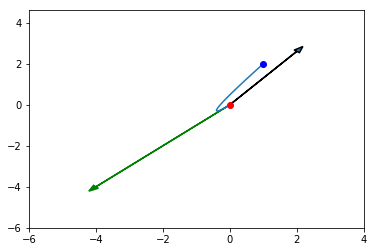

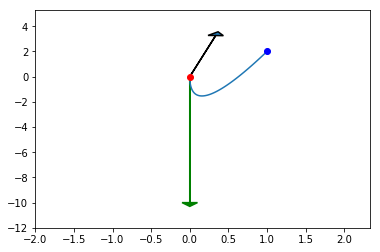

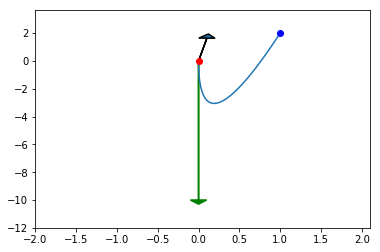

In [18]:
plt.subplots()
print_path(np.array([0,0]),np.array([1,2]),np.array([-4,-4]))
print_path(np.array([0,0]),np.array([1,2]),np.array([0,-10]))
print_path(np.array([0,0]),np.array([1,2]),np.array([0,-10]),F=5*3.28)

## Comparing our trajectories to real ones
-----


The aim is to adjust the value of F. We take the position $a$ of a player at a time t. We look where he is (point $b$) at the time t+$\Delta$t and the trajectory he made during $\Delta$t. With our model, we compute the trajectory to go from $a$ to $b$ and look at the difference between both trajectories. We iterate several time and we do this for several value of F. Then, we can adjust our F value to the one that leads to less errors.

In [19]:
def one_trajectory_error(lx,ly,lxreal,lyreal):
    MSE=0
    for x,y,xreal,yreal in zip(lx,ly,lxreal,lyreal):
        delta=(np.linalg.norm(np.array([xreal-x,yreal-y])))**2
        MSE+=delta
    return MSE
    

In [20]:
def players_ball_speed_position(moment1,moment2):
    team1,team2,ball =[],[],[]
    
    dt=moment1[2]-moment2[2]
    mom_infos={}
    mom_infos['ball']={}
    mom_infos['team1']={}
    mom_infos['team2']={}
    for i in range(11) :
        if i==0:
            mom_infos['ball']['xy']=np.array(moment1[5][i][2:4])
            mom_infos['ball']['z']=moment1[5][i][4]
            mom_infos['ball']['v']=np.array([(moment2[5][i][2]-moment1[5][i][2])/dt,(moment2[5][i][3]-moment1[5][i][3])/dt])
        if 6<=i<=11:
            mom_infos['team2'][str(moment1[5][i][1])]={'xy':np.array(moment1[5][i][2:4]),'v':np.array([(moment2[5][i][2]-moment1[5][i][2])/dt,(moment2[5][i][3]-moment1[5][i][3])/dt])}
        if 1<=i<=5:
            mom_infos['team1'][str(moment1[5][i][1])]={'xy':np.array(moment1[5][i][2:4]),'v':np.array([(moment2[5][i][2]-moment1[5][i][2])/dt,(moment2[5][i][3]-moment1[5][i][3])/dt])}
    return(mom_infos)

In [26]:
def event_trajectory_error(events,eventId,t):
    event=events[eventId]
    moments=event['moments']
    forces=[]
    errors=[]
    times=[]
    vmax=0
    for f in np.arange(3,15,0.5):
        error=[]
        TF=[]
        for mom_id in range(len(moments)-round(t/0.04)-1):
            err=0
            moment1=moments[mom_id]
            moment2=moments[mom_id+1]
            moment1f=moments[mom_id+round(t/0.04)]
            moment2f=moments[mom_id+round(t/0.04)+1]
            mom_infos=players_ball_speed_position(moment1,moment2)
            mom_infos_final=players_ball_speed_position(moment1f,moment2f)
            LX={}
            LY={}
            LXREAL={}
            LYREAL={}
            
            for player in mom_infos['team1'].keys():
                a=mom_infos['team1'][player]['xy']
                v=mom_infos['team1'][player]['v']
                normv=np.linalg.norm(v)
                if normv>vmax:
                    vmax=normv
                b=mom_infos_final['team1'][player]['xy']
                lx,ly,Fx,Fy,tf=path(a,b,v,f*3.28,round(t/0.04))
                LX[player]=lx
                LY[player]=ly
                TF.append(tf-t)
            
            for player in mom_infos['team2'].keys():
                a=mom_infos['team2'][player]['xy']
                v=mom_infos['team2'][player]['v']
                if normv>vmax:
                    vmax=normv
                b=mom_infos_final['team2'][player]['xy']
                lx,ly,Fx,Fy,tf=path(a,b,v,f*3.28,round(t/0.04))
                LX[player]=lx
                LY[player]=ly
                TF.append(tf-t)
            
            for player in mom_infos['team1'].keys():
                LXREAL[player]=[]
                LYREAL[player]=[]
            
            for player in mom_infos['team2'].keys():
                LXREAL[player]=[]
                LYREAL[player]=[]
            
            for i in range(round(t/0.04)+1):
                mom1=moments[mom_id+i]
                mom2=moments[mom_id+i+1]
                mom_infos=players_ball_speed_position(mom1,mom2)
                for player in mom_infos['team1'].keys():
                    LXREAL[player].append(mom_infos['team1'][player]['xy'][0])
                    LYREAL[player].append(mom_infos['team1'][player]['xy'][1])
                
                for player in mom_infos['team2'].keys():
                    LXREAL[player]=LXREAL[player]+[mom_infos['team2'][player]['xy'][0]]
                    LYREAL[player]=LYREAL[player]+[mom_infos['team2'][player]['xy'][1]]
            
            for player in LX.keys():
                if one_trajectory_error(LX[player],LY[player],LXREAL[player],LYREAL[player])>100 and f==10:
                    print('f:',f)
                    print(LX[player][-1],LXREAL[player][-1])
                    print(one_trajectory_error(LX[player],LY[player],LXREAL[player],LYREAL[player]))
                    plt.plot(LX[player],LY[player],'b-o')
                    plt.plot(LXREAL[player],LYREAL[player],'r-o')
                    plt.show()
                error.append(one_trajectory_error(LX[player],LY[player],LXREAL[player],LYREAL[player]))

        errors.append(error)
        forces.append(f)
        times.append(TF)
    return(errors,forces,times,vmax)
        
        

In [27]:
errors,forces,times,vmax=event_trajectory_error(events,0,0.4)

In [28]:
df=pd.DataFrame(errors,index=forces)
df.T.describe()

,3.0,3.5,4.0,4.5,5.0,5.5,6.0,6.5,7.0,7.5,...,10.0,10.5,11.0,11.5,12.0,12.5,13.0,13.5,14.0,14.5
count,1390.000000,1390.000000,1390.000000,1390.000000,1390.000000,1390.000000,1390.000000,1390.000000,1390.000000,1390.000000,...,1390.000000,1390.000000,1390.000000,1390.000000,1390.000000,1390.000000,1390.000000,1390.000000,1390.000000,1390.000000
mean,7.000383,3.571299,1.730967,0.739745,0.172912,0.126790,0.134445,0.144367,0.153696,0.162914,...,0.203958,0.211510,0.218869,0.226041,0.233036,0.239861,0.246522,0.253028,0.259383,0.265595
std,25.125185,14.299185,7.868590,3.834055,0.855666,0.150779,0.148151,0.157657,0.166804,0.176214,...,0.219593,0.227961,0.236223,0.244379,0.252426,0.260366,0.268199,0.275924,0.283543,0.291056
min,0.000523,0.000553,0.000225,0.000324,0.000678,0.000732,0.000778,0.000823,0.000866,0.000908,...,0.001004,0.001016,0.001027,0.001038,0.001048,0.001057,0.001061,0.001064,0.001066,0.001069
25%,0.015009,0.018392,0.022072,0.025327,0.028307,0.031046,0.033599,0.036048,0.037973,0.040395,...,0.048957,0.050034,0.051954,0.053262,0.054228,0.055372,0.056315,0.056976,0.057844,0.058396
50%,0.037915,0.042008,0.049053,0.055168,0.062250,0.069009,0.075176,0.082498,0.088294,0.095277,...,0.121153,0.125268,0.128501,0.132100,0.136822,0.140747,0.144272,0.147158,0.151122,0.153811
75%,0.110344,0.110928,0.120973,0.135105,0.146445,0.158111,0.169694,0.184833,0.196446,0.208562,...,0.259637,0.271789,0.281417,0.288140,0.298239,0.310769,0.318061,0.324690,0.330517,0.337746
max,187.777031,112.941783,67.577695,38.338453,17.494064,2.268599,0.895568,0.954281,1.007739,1.057114,...,1.263365,1.298810,1.332794,1.365450,1.396892,1.427216,1.456507,1.484838,1.512274,1.538874


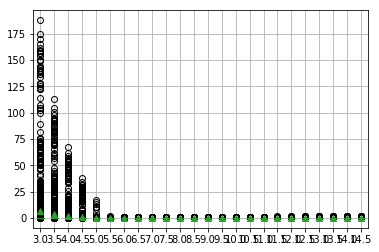

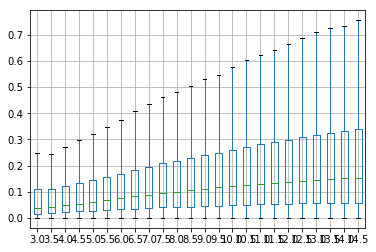

In [29]:
plt.subplots()
plt.figure(1)
df.T.boxplot(showmeans=True)
plt.figure(2)
df.T.boxplot(showfliers=False)
plt.show()

In [30]:
df2=pd.DataFrame(times,index=forces)
df2.T.describe()

,3.0,3.5,4.0,4.5,5.0,5.5,6.0,6.5,7.0,7.5,...,10.0,10.5,11.0,11.5,12.0,12.5,13.0,13.5,14.0,14.5
count,1390.000000,1390.000000,1390.000000,1390.000000,1390.000000,1390.000000,1390.000000,1390.000000,1390.000000,1390.000000,...,1390.000000,1390.000000,1390.000000,1390.000000,1390.000000,1390.000000,1390.000000,1390.000000,1390.000000,1390.000000
mean,0.058635,-0.021414,-0.078869,-0.116022,-0.146295,-0.156929,-0.164487,-0.170948,-0.176681,-0.181983,...,-0.202666,-0.206037,-0.209215,-0.212220,-0.215068,-0.217773,-0.220347,-0.222802,-0.225146,-0.227388
std,0.432820,0.317365,0.226233,0.154157,0.081381,0.067318,0.064593,0.063438,0.062500,0.061849,...,0.058396,0.057812,0.057253,0.056717,0.056201,0.055703,0.055222,0.054757,0.054306,0.053870
min,-0.339533,-0.341411,-0.343091,-0.349130,-0.352787,-0.355259,-0.357142,-0.358670,-0.359960,-0.361079,...,-0.365170,-0.365798,-0.366383,-0.366931,-0.367446,-0.367932,-0.368391,-0.368827,-0.369564,-0.370299
25%,-0.153774,-0.168597,-0.180512,-0.189520,-0.198190,-0.205497,-0.211913,-0.217714,-0.222730,-0.227430,...,-0.245353,-0.248016,-0.250599,-0.253435,-0.256083,-0.258600,-0.260675,-0.263003,-0.265031,-0.266831
50%,-0.092358,-0.110078,-0.124320,-0.136155,-0.146079,-0.154649,-0.163377,-0.170893,-0.177240,-0.182140,...,-0.204942,-0.208476,-0.211529,-0.214441,-0.217369,-0.220297,-0.223094,-0.225571,-0.227957,-0.230292
75%,-0.013826,-0.044563,-0.068770,-0.084132,-0.098574,-0.108682,-0.116323,-0.123699,-0.129139,-0.134885,...,-0.157381,-0.161174,-0.164528,-0.168250,-0.171695,-0.174631,-0.177775,-0.180629,-0.183281,-0.186268
max,1.799531,1.394079,1.076804,0.809368,0.544507,0.198360,0.040541,-0.004616,-0.029421,-0.042282,...,-0.077364,-0.083119,-0.088551,-0.093690,-0.098562,-0.103190,-0.107594,-0.111793,-0.115803,-0.119637


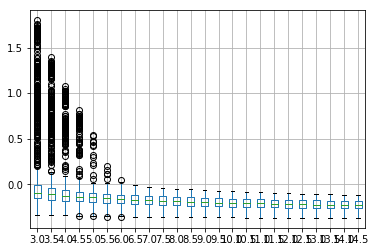

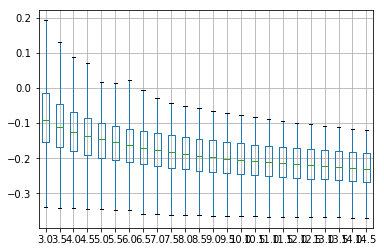

In [31]:
plt.subplots()
plt.figure(1)
df2.T.boxplot()
plt.figure(2)
df2.T.boxplot(showfliers=False)
plt.show()

## Sources 
[1] Akira Fujimura and Kokichi Sugihara. Geometric analysis and quantitative evaluation of sport teamwork. *Systems and Computers in Japan*, 36(6):49–58, 2005.